In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from superfv import OutputLoader

In [2]:
base_path = "/scratch/gpfs/jp7427/out/profiling-2d-square/"

common = dict(PAD={"rho": (0, None), "P": (0, None)})
apriori = dict(ZS=True, lazy_primitives="adaptive", **common)
aposteriori = dict(
    MOOD=True,
    lazy_primitives="full",
    MUSCL_limiter="PP2D",
    NAD_rtol=0,
    NAD_atol=0,
    **common,
)

configs = {
    "p0": dict(p=0),
    "MUSCL-Hancock": dict(p=1, MUSCL=True, MUSCL_limiter="PP2D", **common),
    "MUSCL3": dict(p=1, MUSCL=True, MUSCL_limiter="PP2D", CFL=0.5, **common),
    "p3t": dict(p=3),
    "p7t": dict(p=7),
    "p3gl": dict(p=3, GL=True),
    "p7gl": dict(p=7, GL=True),
    "ZS3": dict(p=3, GL=True, **apriori),
    "ZS7": dict(p=7, GL=True, **apriori),
    "ZS3t": dict(p=3, adaptive_dt=False, **apriori),
    "ZS7t": dict(p=7, adaptive_dt=False, **apriori),
    "MM3": dict(p=3, skip_trouble_counts=True, **aposteriori),
    "MM7": dict(p=7, skip_trouble_counts=True, **aposteriori),
    "MM3-2": dict(p=3, cascade="muscl1", max_MOOD_iters=2, **aposteriori),
    "MM7-2": dict(p=7, cascade="muscl1", max_MOOD_iters=2, **aposteriori),
    "MM3-3": dict(p=3, cascade="muscl1", max_MOOD_iters=3, **aposteriori),
    "MM7-3": dict(p=7, cascade="muscl1", max_MOOD_iters=3, **aposteriori),
}

n_steps = 10
N_values = [64, 128, 256, 512, 1024, 2048]
devices = ["gpu", "cpu"]

data = []
for device, (name, config), N in product(devices, configs.items(), N_values):
    try:
        sim_path = f"{base_path}{device}/{name}/N_{N}/"
        sim = OutputLoader(sim_path)

        update_rates = sim.minisnapshots["update_rate"]
        substep_update_rates = sim.minisnapshots["substep_update_rate"]
        entry = dict(
            config=name,
            N=N,
            update_rate=np.mean(update_rates[1:]),
            substep_update_rate=np.mean(substep_update_rates[1:]),
            device=device,
        )
        data.append(entry)
    except FileNotFoundError:
        continue
df = pd.DataFrame(data)

Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/gpu/p0/N_64"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/gpu/p0/N_128"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/gpu/p0/N_256"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/gpu/p0/N_512"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/gpu/p0/N_1024"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/gpu/p0/N_2048"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/gpu/MUSCL-Hancock/N_64"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/gpu/MUSCL-Hancock/N_128"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/profiling-2d-square/gpu/MUSCL-Hancock/N_256"
Successfully read simulation output from "/scratch/gpfs/jp

/tmp/ipykernel_1824114/1790712483.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["config"] = df_filtered["config"].astype(
/tmp/ipykernel_1824114/1790712483.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for config, df_name in df_sorted.groupby("config"):
/tmp/ipykernel_1824114/1790712483.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

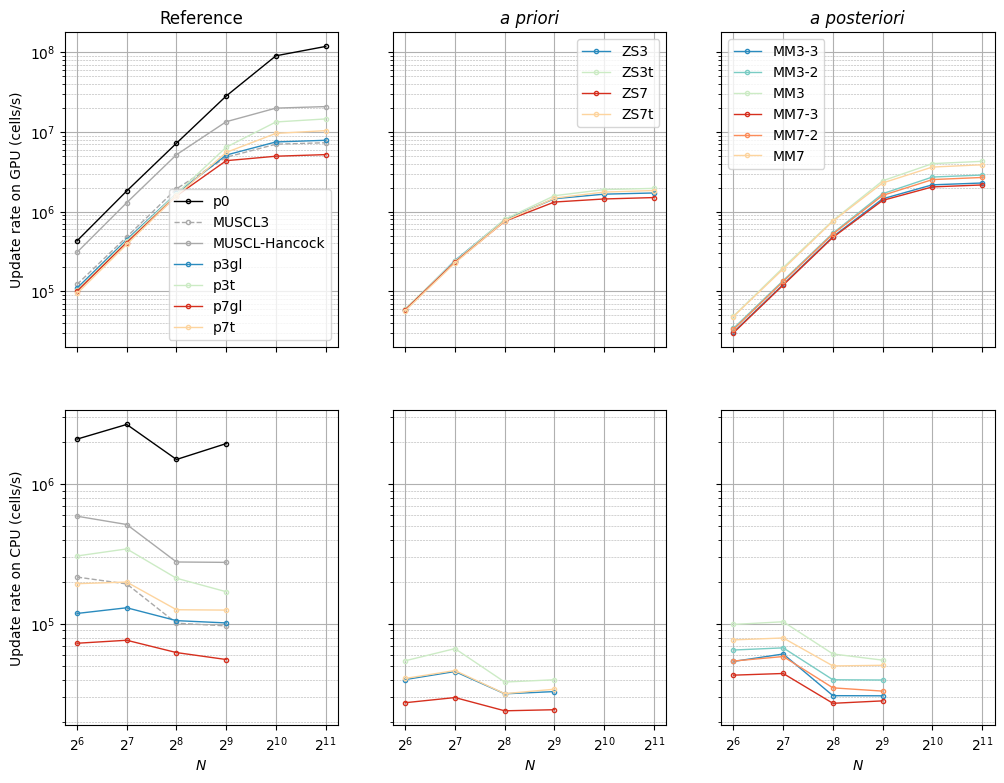

In [3]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey="row", figsize=(12, 9))
axs[0, 0].set_title("Reference")
axs[0, 1].set_title("a priori", fontstyle="italic")
axs[0, 2].set_title("a posteriori", fontstyle="italic")
axs[0, 0].set_ylabel("Update rate on GPU (cells/s)")
axs[1, 0].set_ylabel("Update rate on CPU (cells/s)")

for i, j in product(range(2), range(3)):
    axs[i, j].set_xscale("log", base=2)
    axs[i, j].set_yscale("log")

    if i == 1:
        axs[1, j].set_xlabel(r"$N$")

    axs[i, j].grid(which="major", linestyle="-", linewidth=0.8)
    axs[i, j].grid(which="minor", linestyle="--", linewidth=0.4)

subsets = (
    ["p0", "MUSCL3", "MUSCL-Hancock", "p3gl", "p3t", "p7gl", "p7t"],
    ["ZS3", "ZS3t", "ZS7", "ZS7t"],
    ["MM3-3", "MM3-2", "MM3", "MM7-3", "MM7-2", "MM7"],
)

common_style = dict(linewidth=1, marker="o", mfc="none", markersize=3)

cmap1 = plt.get_cmap("GnBu")
cmap2 = plt.get_cmap("OrRd")

styles = {
    "p0": dict(color="k"),
    "MUSCL3": dict(color="darkgrey", linestyle="--"),
    "MUSCL-Hancock": dict(color="darkgrey"),
    "p3t": dict(color=cmap1(0.25)),
    "p7t": dict(color=cmap2(0.25)),
    "p3gl": dict(color=cmap1(0.75)),
    "p7gl": dict(color=cmap2(0.75)),
    "ZS3": dict(color=cmap1(0.75)),
    "ZS7": dict(color=cmap2(0.75)),
    "ZS3t": dict(color=cmap1(0.25)),
    "ZS7t": dict(color=cmap2(0.25)),
    "MM3": dict(color=cmap1(0.25)),
    "MM7": dict(color=cmap2(0.25)),
    "MM3-2": dict(color=cmap1(0.5)),
    "MM7-2": dict(color=cmap2(0.5)),
    "MM3-3": dict(color=cmap1(0.75)),
    "MM7-3": dict(color=cmap2(0.75)),
}

for device in devices:
    i = 0 if device == "gpu" else 1
    for j, subset in enumerate(subsets):
        df_filtered = df[df["config"].isin(subset) & (df["device"] == device)]
        df_filtered["config"] = df_filtered["config"].astype(
            pd.CategoricalDtype(subset, ordered=True)
        )
        df_sorted = df_filtered.sort_values(by=["config", "N"])

        for config, df_name in df_sorted.groupby("config"):
            axs[i, j].plot(
                df_name["N"],
                df_name["update_rate"],
                label=config,
                **common_style,
                **styles[config],
            )

        if i == 0:
            axs[0, j].legend()

In [4]:
fig.savefig("timing.png", dpi=300)

/tmp/ipykernel_1824114/1841996126.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["config"] = df_filtered["config"].astype(
/tmp/ipykernel_1824114/1841996126.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for config, df_name in df_sorted.groupby("config"):
/tmp/ipykernel_1824114/1841996126.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

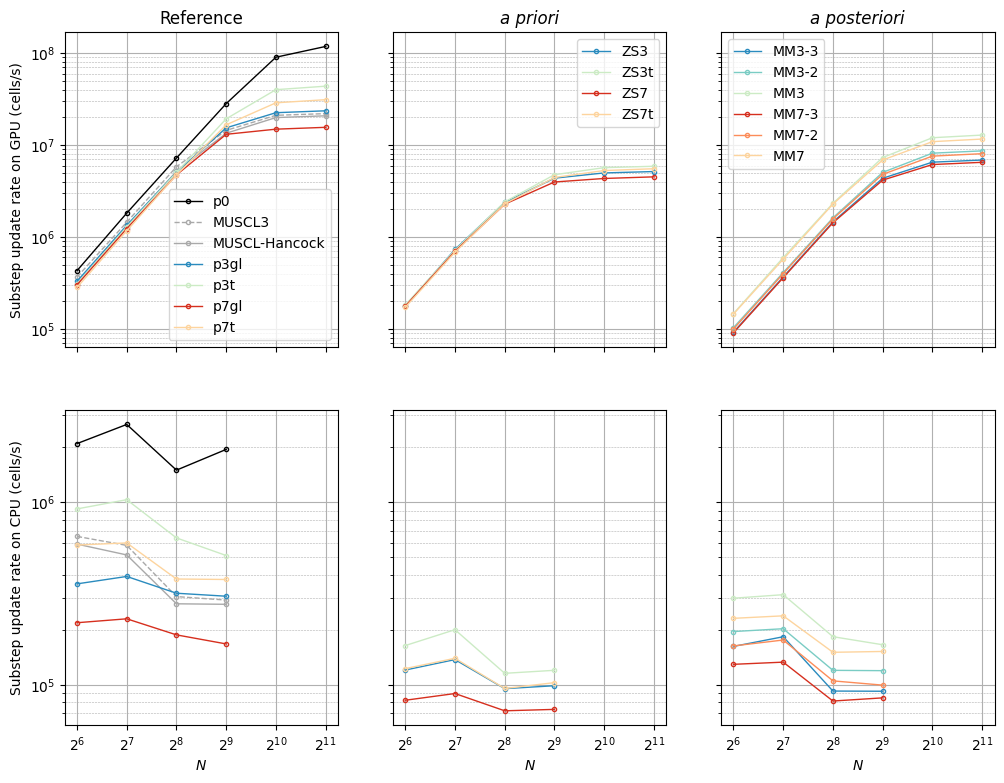

In [5]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey="row", figsize=(12, 9))
axs[0, 0].set_title("Reference")
axs[0, 1].set_title("a priori", fontstyle="italic")
axs[0, 2].set_title("a posteriori", fontstyle="italic")
axs[0, 0].set_ylabel("Substep update rate on GPU (cells/s)")
axs[1, 0].set_ylabel("Substep update rate on CPU (cells/s)")

for i, j in product(range(2), range(3)):
    axs[i, j].set_xscale("log", base=2)
    axs[i, j].set_yscale("log")

    if i == 1:
        axs[1, j].set_xlabel(r"$N$")

    axs[i, j].grid(which="major", linestyle="-", linewidth=0.8)
    axs[i, j].grid(which="minor", linestyle="--", linewidth=0.4)

subsets = (
    ["p0", "MUSCL3", "MUSCL-Hancock", "p3gl", "p3t", "p7gl", "p7t"],
    ["ZS3", "ZS3t", "ZS7", "ZS7t"],
    ["MM3-3", "MM3-2", "MM3", "MM7-3", "MM7-2", "MM7"],
)

common_style = dict(linewidth=1, marker="o", mfc="none", markersize=3)

cmap1 = plt.get_cmap("GnBu")
cmap2 = plt.get_cmap("OrRd")

styles = {
    "p0": dict(color="k"),
    "MUSCL3": dict(color="darkgrey", linestyle="--"),
    "MUSCL-Hancock": dict(color="darkgrey"),
    "p3t": dict(color=cmap1(0.25)),
    "p7t": dict(color=cmap2(0.25)),
    "p3gl": dict(color=cmap1(0.75)),
    "p7gl": dict(color=cmap2(0.75)),
    "ZS3": dict(color=cmap1(0.75)),
    "ZS7": dict(color=cmap2(0.75)),
    "ZS3t": dict(color=cmap1(0.25)),
    "ZS7t": dict(color=cmap2(0.25)),
    "MM3": dict(color=cmap1(0.25)),
    "MM7": dict(color=cmap2(0.25)),
    "MM3-2": dict(color=cmap1(0.5)),
    "MM7-2": dict(color=cmap2(0.5)),
    "MM3-3": dict(color=cmap1(0.75)),
    "MM7-3": dict(color=cmap2(0.75)),
}

for device in devices:
    i = 0 if device == "gpu" else 1
    for j, subset in enumerate(subsets):
        df_filtered = df[df["config"].isin(subset) & (df["device"] == device)]
        df_filtered["config"] = df_filtered["config"].astype(
            pd.CategoricalDtype(subset, ordered=True)
        )
        df_sorted = df_filtered.sort_values(by=["config", "N"])

        for config, df_name in df_sorted.groupby("config"):
            axs[i, j].plot(
                df_name["N"],
                df_name["substep_update_rate"],
                label=config,
                **common_style,
                **styles[config],
            )

        if i == 0:
            axs[0, j].legend()

In [6]:
fig.savefig("substep_timing.png", dpi=300)